In [9]:
from keras import backend as K
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


In [10]:
with open('Desktop/data/processed/train.json') as f:
      train = json.load(f)

In [11]:
with open('Desktop/data/processed/test.json') as f:
      test = json.load(f)

In [12]:
def normalize(X1):
    '''normalizes to 0 to 1 scale'''
    norm = ((X1-X1.min())/(X1.max()-X1.min()))
    return norm

def preprocess(data):
    '''
    preprocesses the data and returns two list of processed data, 
    one normalized on 0 to 1 scale, dual channel picture, 75x75x2
    one normalized to power ratio, and combined, single channel picture, 75x75x1
    '''
    #make empty list for dataset normalized from 0 to 1
    X_data_scale = list()

    #make empty list for dataset normalized by power ratio
    X_data_power = list()

    #itterate over each element of the data
    for i in range(len(data)):
        #get elements of entry
        id = (data[i]['id'])
        B1 = np.reshape(data[i]['band_1'], (75,75))
        B2 = np.reshape(data[i]['band_2'], (75,75))
        
        #normalize to 0 to 1 range
        B1_norm = normalize(B1)
        B2_norm = normalize(B2)
        norm_merge = np.dstack((B1_norm,B2_norm))
        
        #transform to power
        B1_power = np.power(10, np.divide(B1, 20))
        B2_power = np.power(10, np.divide(B2, 20))
        power_merge = normalize(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_power,10)),np.power(10,np.divide(B2_power,10))))))

        #df.append({'id':id, 'image':norm_merge})
        #dp.append({'id':id, 'image':power_merge})
        X_data_scale.append(norm_merge)
        X_data_power.append(power_merge)
        
    return np.array(X_data_scale), np.array(X_data_power)

def get_classification(data):
    '''retrieves classification for each image in testing dataset'''
    y_data = list()
    for i in range(len(data)):
        #id = (data[i]['id'])
        classification = (data[i]['is_iceberg'])
        #target.append({'id':id, 'is_iceberg':classification})
        y_data.append([classification])
    return(np.array(y_data))

def get_id(data):
    '''retrieves classification for each image in testing dataset'''
    id = list()
    for i in range(len(data)):
        sample = (data[i]['id'])
        id.append([sample])
    return(np.array(id))

def get_angle(data):
    '''retrieves classification for each image in testing dataset'''
    angle = list()
    for i in range(len(data)):
        sample = (data[i]['inc_angle'])
        angle.append(sample)
    return(angle)

In [13]:
X_train_scale, X_train_power = preprocess(train)
y_train = get_classification(train)
train_id = get_id(train)

In [14]:
X_test_scale, X_test_power = preprocess(test)
test_id = get_id(test)

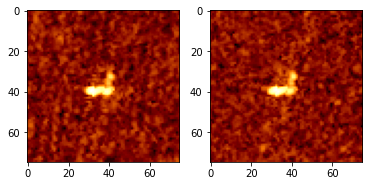

In [15]:
fig = plt.figure()
plt.subplot(121)
B1_norm = normalize(np.reshape(train[1]['band_1'], (75,75)))
plt.imshow(B1_norm, cmap='afmhot')
plt.subplot(122)
B2_norm = normalize(np.reshape(train[1]['band_2'], (75,75)))
plt.imshow(B2_norm, cmap='afmhot')
plt.show()

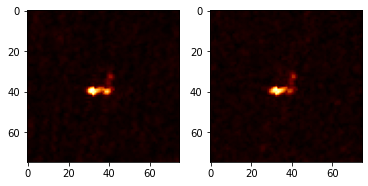

In [16]:
fig = plt.figure()
plt.subplot(121)
B1_power = np.power(10, np.divide(np.reshape(train[1]['band_1'], (75,75)), 20))
plt.imshow(B1_power, cmap='afmhot')
plt.subplot(122)
B2_power = np.power(10, np.divide(np.reshape(train[1]['band_2'], (75,75)), 20))
plt.imshow(B2_power, cmap='afmhot')
plt.show()


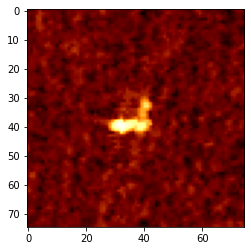

In [17]:
dd=(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_norm,10)),np.power(10,np.divide(B2_norm,10))))))
plt.imshow(dd, cmap='afmhot')

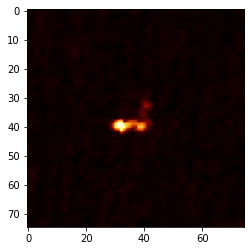

In [18]:
dm=(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_power,10)),np.power(10,np.divide(B2_power,10))))))
plt.imshow(dm, cmap='afmhot')

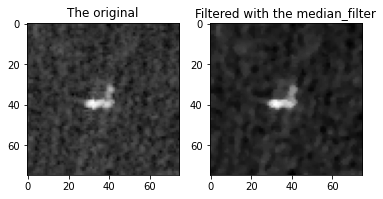

In [19]:
from scipy.ndimage.filters import median_filter
from matplotlib.pylab import imread, imshow, subplot, title, show, get_cmap

img = dd
new = median_filter(img, 3)

subplot(121); imshow(img, cmap=get_cmap('gray'));
title('The original')
subplot(122); imshow(new, cmap=get_cmap('gray'));
title('Filtered with the median_filter')

show()

In [20]:
from sklearn.model_selection import train_test_split
X_train_d_scale, X_test_d_scale, y_train_d_scale, y_test_d_scale = train_test_split(X_train_scale, y_train, test_size=0.2, random_state=0)

In [21]:
batch_size = 32 #number of training examples to consider at once
num_epochs = 5 #itterate n times over training set
kernel_size = 3 #3x3 kernal
pool_size = 2 #2x2 pooling
conv_depth_1 = 32 # first layer 32 kernals
conv_depth_2 = 64 # second layer 64 kernals
drop_prob_1 = 0.2 # probability of dropout after pooling
drop_prob_2 = 0.65 # probability of dropout in fully-connected layer
hidden_size = 512 #number of neurons in fully-connected layer

In [22]:
num_train, height, width, depth = X_train_scale.shape  #1604 training samples
num_test = X_test_scale.shape[0] #8424 testing samples
num_classes = np.unique(y_train).shape[0] #number of unique classes (iceberg: yes(1), no(0))

In [23]:
Y_train = np_utils.to_categorical(y_train_d_scale, num_classes)
Y_test = np_utils.to_categorical(y_test_d_scale, num_classes)

In [24]:
inp = Input(shape=(height, width, depth)) 

# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden = Dense(hidden_size, activation='relu')(flat)
drop_3 = Dropout(drop_prob_2)(hidden)
out = Dense(num_classes, activation='softmax')(drop_3)

model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

history = model.fit(X_train_d_scale, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
model.evaluate(X_test_d_scale, Y_test, verbose=1)  # Evaluate the trained model on the test set!

Epoch 1/5
37/37 [==============================] - 23s 614ms/step - loss: 0.7799 - accuracy: 0.5147 - val_loss: 0.6730 - val_accuracy: 0.6434
Epoch 2/5
37/37 [==============================] - 22s 596ms/step - loss: 0.6426 - accuracy: 0.6083 - val_loss: 0.5659 - val_accuracy: 0.6744
Epoch 3/5
37/37 [==============================] - 22s 596ms/step - loss: 0.6049 - accuracy: 0.6586 - val_loss: 0.5573 - val_accuracy: 0.6822
Epoch 4/5
37/37 [==============================] - 22s 597ms/step - loss: 0.6112 - accuracy: 0.6681 - val_loss: 0.5621 - val_accuracy: 0.6744
Epoch 5/5
11/11 [==============================] - 1s 117ms/step - loss: 0.5994 - accuracy: 0.6729


[0.5994158983230591, 0.672897219657898]

In [25]:
dd=model.predict(X_test_scale,batch_size=batch_size,verbose=1)

264/264 [==============================] - 36s 135ms/step


In [26]:
results = pd.DataFrame()

for i in range(len(test_id)):
    results = results.append({'id': test_id[i][0], 'is_iceberg' :dd[i][1]}, ignore_index=True)

results.to_csv("results.csv",index=False)

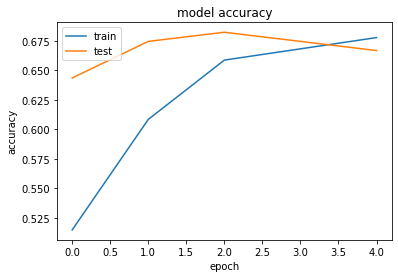

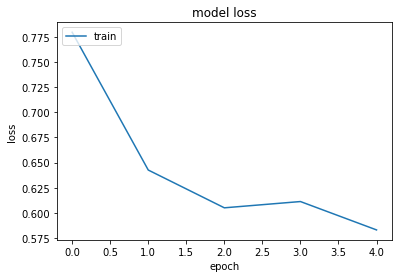

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 75, 32)        608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)       

In [29]:
import keras2onnx

onnx_model = keras2onnx.convert_keras(model,'ice-berg-onnx',debug_mode=1)
output_model_path = "./ice-berg.onnx"
keras2onnx.save_model(onnx_model, output_model_path)

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense_1: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense_1/Softmax:0
	input : dropout_2/cond/Identity:0
Processing a keras layer - (dropout_2: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout_2/cond/Identity:0
	input : dense/Relu:0
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Relu:0
	input : flatten/Reshape:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Reshape:0
	input : dropout_1/cond/Identity:0
Processing a keras layer - (dropout_1: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout_1/cond/Identity:0
	input : max_pooling2d_1/MaxPool:0
Processing a keras layer - (max_pooling2d_1: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d_1/MaxPool:0
	input : conv2d_3/Relu:0
Processing 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 2)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 75, 32)        608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)       

Converting the operator (flatten): <class 'tensorflow.python.keras.layers.core.Flatten'>
Converting the operator (flatten/Const): Const
Converting the operator (dropout_1): <class 'tensorflow.python.keras.layers.core.Dropout'>
Converting the operator (max_pooling2d_1): <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>
Converting the operator (conv2d_3): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (conv2d_2): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (dropout): <class 'tensorflow.python.keras.layers.core.Dropout'>
Converting the operator (max_pooling2d): <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>
Converting the operator (conv2d_1): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (conv2d): <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>
Converting the operator (Identity3): Identity


In [3]:
import onnx
from onnx import numpy_helper
onnx_model   = onnx.load("ice-berg.onnx")
INTIALIZERS  = onnx_model.graph.initializer
nodes=onnx_model.graph.node
onnx_weights = {}
onnx_nodes = {}
for initializer in INTIALIZERS:
    W = numpy_helper.to_array(initializer)
    print(initializer.name)
    onnx_weights[initializer.name] = W
for node in nodes:
    print(node.name)

dense_1/kernel:0
dense_1/bias:0
dense/kernel:0
dense/bias:0
conv2d_3/kernel:0
conv2d_3/bias:0
conv2d_2/kernel:0
conv2d_2/bias:0
conv2d_1/kernel:0
conv2d_1/bias:0
conv2d/kernel:0
conv2d/bias:0
Identity4
Identity5
Identity6
dense_1
Add
Softmax
Identity7
dense
Add1
Relu
flatten
Identity8
Transpose
conv2d_3/Relu:0_pooling
conv2d_3/Relu:0_transpose

Transpose1
conv2d_3
Transpose2
Relu1
Transpose3
conv2d_2
Transpose4
Relu2
Identity9
Transpose5
conv2d_1/Relu:0_pooling
conv2d_1/Relu:0_transpose

Transpose6
conv2d_1
Transpose7
Relu3
Transpose8
conv2d
Transpose9
Relu4
Identity10


In [31]:
for i in onnx_weights:
  print(len(i))

16
14
14
12
17
15
17
15
17
15
15
13


In [13]:
print(onnx_weights.keys())
ky=list(onnx_weights.keys())

dict_keys(['dense_1/kernel:0', 'dense_1/bias:0', 'dense/kernel:0', 'dense/bias:0', 'conv2d_3/kernel:0', 'conv2d_3/bias:0', 'conv2d_2/kernel:0', 'conv2d_2/bias:0', 'conv2d_1/kernel:0', 'conv2d_1/bias:0', 'conv2d/kernel:0', 'conv2d/bias:0'])


In [14]:
print(onnx_weights['dense_1/kernel:0'])

[[-0.03151594 -0.03325264]
 [ 0.00939007 -0.10283265]
 [-0.02109723  0.03590563]
 ...
 [-0.0278501  -0.02431278]
 [ 0.04854633  0.10295112]
 [ 0.07330242 -0.07048109]]


In [15]:
lt=len(onnx_weights)
print(lt)

12


In [26]:
layer_weights={}
layer_biases = {}
k=j=1
for i in range(lt):
    
    v=ky[i].find('bias')
    
    if (v == -1):
        k=str(k)
        layer_weights['L'+k]=onnx_weights[ky[i]]
        k=int(int(k)+1)
    else :
        j=str(j)
        layer_biases['L'+j]=onnx_weights[ky[i]]
        j=int(int(j)+1)

    
    
    

In [27]:
for i in layer_weights:
    print(len(i))

2
2
2
2
2
2


In [28]:
print(layer_weights)

{'L1': array([[-0.03151594, -0.03325264],
       [ 0.00939007, -0.10283265],
       [-0.02109723,  0.03590563],
       ...,
       [-0.0278501 , -0.02431278],
       [ 0.04854633,  0.10295112],
       [ 0.07330242, -0.07048109]], dtype=float32), 'L2': array([[ 6.6724932e-04,  1.7449901e-02,  7.0265476e-03, ...,
        -1.1792408e-02,  7.5284615e-03, -2.4786219e-03],
       [ 1.6744167e-02, -7.6075050e-04, -4.4653397e-03, ...,
        -9.3100552e-06,  9.9113276e-03,  1.3648438e-02],
       [-1.0126438e-02,  9.4747567e-04,  1.3533126e-02, ...,
        -4.1121603e-03, -1.0963405e-02,  4.7101355e-03],
       ...,
       [-2.0882241e-02, -1.7814029e-02,  2.3682019e-02, ...,
        -1.2721934e-02, -1.0150465e-02, -2.0739170e-02],
       [ 3.9559226e-03,  1.0724888e-02, -1.4974815e-02, ...,
        -1.2068023e-02, -9.8424777e-03, -6.9981329e-03],
       [-2.5122024e-03,  4.0394445e-03, -7.6895421e-03, ...,
        -1.8150164e-02,  9.7323311e-03, -1.8669246e-02]], dtype=float32), 'L3': array

In [29]:
for i in layer_biases:
    print(len(i))

2
2
2
2
2
2


In [21]:
print(layer_biases)

{'L1': array([-0.01332949,  0.01332949], dtype=float32), 'L2': array([-0.00557094,  0.01105492,  0.0357248 , -0.0104286 , -0.00460578,
       -0.00727742,  0.01900373,  0.00086029, -0.00913878,  0.00143395,
        0.0165293 , -0.01687561, -0.00587979, -0.00878896, -0.00867427,
        0.00230663, -0.01527864,  0.00396593, -0.0105952 , -0.0059427 ,
       -0.00194941, -0.00693676, -0.01396311,  0.00039559, -0.0097952 ,
       -0.00125432, -0.00600472, -0.00600262,  0.01614866, -0.00026947,
       -0.00195239, -0.00979392, -0.01295582, -0.0113226 , -0.00570588,
       -0.0033891 , -0.00600477,  0.01547166,  0.01465759, -0.00811635,
       -0.00257914,  0.01896391, -0.00600391, -0.00600431, -0.0025077 ,
       -0.00563395, -0.00480614,  0.01607827, -0.00325028,  0.00849971,
       -0.01024686, -0.00490474,  0.0109281 , -0.00319347,  0.00737766,
       -0.00600474, -0.01451241, -0.00430031, -0.00962283, -0.0141725 ,
       -0.00600451, -0.02223836, -0.00578383, -0.00629439, -0.00368603,
 